In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
import dmm_gcp as gcp
import dmm_cp as cp
import palser as pals
import ntpoly as nt

# Note: using np.sum(A * B.T) for matrices A, B is equivalent to Trace(A^dag B)

In [2]:
# First generate a random hamiltonian of the Huckel model
# i.e. alpha on the diagonal, and beta on the off-diagonals to represent nearest neighbors
#    for now use random alpha and beta
np.random.seed(2)
alpha = np.random.random()
beta = np.random.random()

# define the dimensions of the Hamiltonian and how many elements to consider before cutoff
size = 50
n_cutoff = 9
H = pals.generate_H(n_cutoff, size, beta, alpha)
H_spect = linalg.eigvalsh(H)

# define a chemical potential mu (middle of eigenvalue spectrum)
num_electrons = int(0.5*H.shape[0])
mu = (H_spect[num_electrons] + H_spect[num_electrons-1])/2

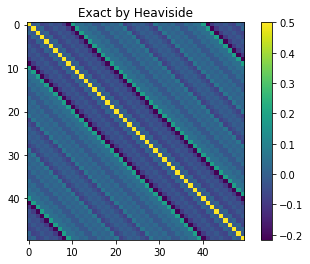

<ipython-input-3-e54ae9e26e73>:11: RuntimeWarning: overflow encountered in exp
  exact3 = linalg.funm(H, lambda _: 1/(1+np.exp(3000*(_ - mu))))


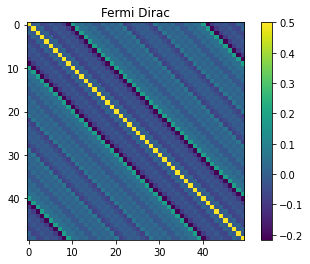

In [3]:
# Exact answers using Heaviside step function and Fermi-dirac statistics
# Heaviside - this simulates 0 tempurature

exact_2 = linalg.funm(H, lambda _: _ <= mu)
plt.imshow(exact_2.real)
plt.title("Exact by Heaviside")
plt.colorbar()
plt.show()

# Fermi-Dirac - this simulates infinite temperature
exact3 = linalg.funm(H, lambda _: 1/(1+np.exp(3000*(_ - mu))))
plt.imshow(exact3.real)
plt.title("Fermi Dirac")
plt.colorbar()
plt.show()

GCP steps:  19
CP steps:  19


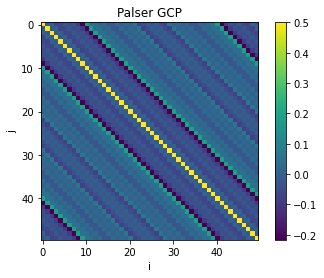

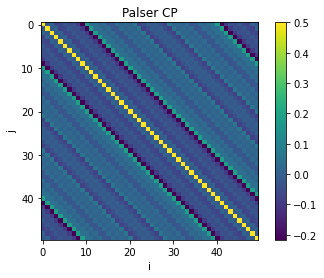

In [4]:
# Perform Palser GCP method
palser_gcp_rho = pals.gcp(mu, H, 1000)
palser_gcp_energy = np.sum(palser_gcp_rho * H.T)

palser_cp_rho = pals.cp(num_electrons, H, 1000)
palser_cp_energy = np.sum(palser_cp_rho * H.T)

plt.figure(1)
plt.imshow(palser_gcp_rho.real)
plt.title("Palser GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.imshow(palser_cp_rho.real)
plt.title("Palser CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

[0.49928242 0.49944546 0.49944546 0.49980891 0.49980891 0.49993992
 0.49993992 0.49994127 0.49994127 0.49996551 0.49996551 0.49997728
 0.49997728 0.49998549 0.49998549 0.49998862 0.49998862 0.49999274
 0.49999274 0.50000061 0.50000061 0.50000986 0.50000986 0.50001132
 0.50001132 0.50002383 0.50002383 0.50003143 0.50003143 0.50003566
 0.50003566 0.50004797 0.50004797 0.5000602  0.5000602  0.5000602
 0.5000602  0.5000602  0.5000602  0.5000602  0.5000602  0.5000602
 0.50006393 0.50006393 0.50009161 0.50009161 0.50010968 0.50010968
 0.50017738 0.50017738]
[-5.91888336e-14 -5.10852054e-14 -4.41005097e-14 -2.82269509e-14
 -2.56935609e-14 -1.91183437e-14 -1.17155291e-14 -1.06722019e-14
 -7.91887514e-15 -8.21906628e-16  3.00742731e-15  7.25411885e-15
  1.65671618e-14  2.21190783e-14  3.13198599e-14  5.36795312e-14
  6.99717667e-14  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.

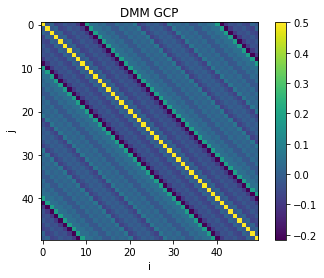

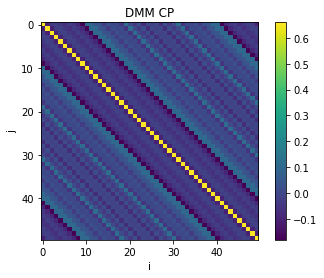

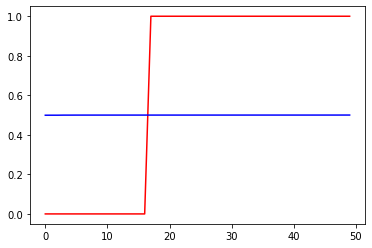

In [5]:
# perform our GCP and CP methods
dbeta = 0.003
ovlp = np.identity(H.shape[0], dtype=complex)
#inv_ovlp = linalg.inv(ovlp)
init_rho = ovlp/2

dmm_gcp_rho = gcp.rk4(gcp.rhs, init_rho, 0.003, H, ovlp, ovlp, mu, 1000)
dmm_cp_rho = cp.rk4(cp.rhs, init_rho, 0.003, H, ovlp, ovlp, 1000)

plt.figure(1)
plt.imshow(dmm_gcp_rho.real)
plt.title("DMM GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.imshow(dmm_cp_rho.real)
plt.title("DMM CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

print(linalg.eigvalsh(init_rho))
print(linalg.eigvalsh(dmm_cp_rho))

plt.figure(3)
plt.plot(linalg.eigvalsh(dmm_cp_rho), 'r-', label='cp_eigs')
plt.plot(linalg.eigvalsh(init_rho), 'b-', label='init_eigs')

print(linalg.norm(init_rho @ init_rho - init_rho))
print(linalg.norm(dmm_cp_rho @ dmm_cp_rho - dmm_cp_rho))

Iterations converged!


Text(0.5, 0, 'Iteration #')

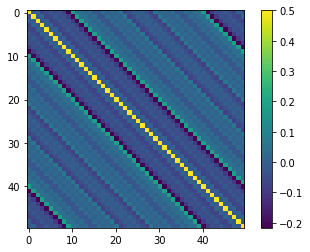

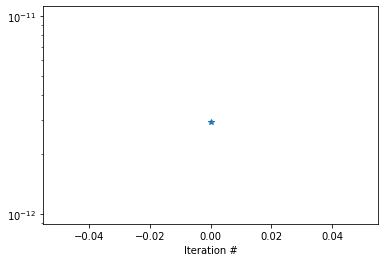

In [6]:
# Apply Aitkens convergence to our methods
func_args = {'h': H, 'mu': mu, 'inv_ovlp': ovlp, 'dbeta': dbeta, 'rk4steps': 1000}
gcp_aitkens, norm_diff = gcp.aitkens(dmm_gcp_rho.copy(), 50, gcp.linear_single_step, **func_args)

plt.figure(1)
plt.imshow(gcp_aitkens.real)
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, '*-')
plt.xlabel("Iteration #")

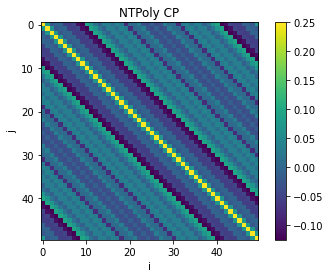

In [7]:
# perform method using NTPoly (Only CP for now)
ntpoly_cp_rho = nt.NTPoly_cp(H, ovlp, num_electrons)

plt.imshow(ntpoly_cp_rho.real)
plt.title("NTPoly CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

Iterations converged!


Text(0.5, 0, 'Iteration #')

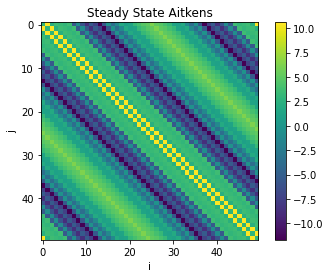

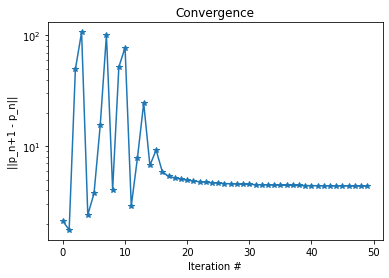

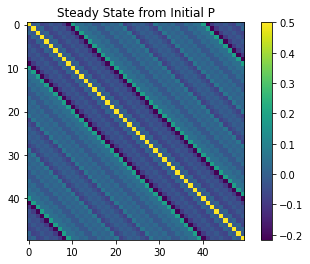

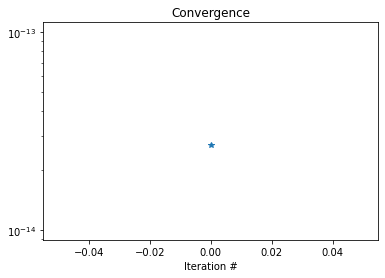

In [8]:
# Steady state convergence method
func_args = {'h':H, 'mu': mu, 'inv_ovlp': ovlp}
steady_state_aitkens, norm_diff = gcp.aitkens(init_rho.copy(), 50, gcp.steady_linear_single_step, **func_args)

plt.figure(1)
plt.imshow(steady_state_aitkens.real)
plt.title("Steady State Aitkens")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, '*-')
plt.xlabel("Iteration #")
plt.ylabel("||p_n+1 - p_n||")
plt.title("Convergence")

steady_state_aitkens2, norm_diff = gcp.aitkens(exact_2.copy(), 50, gcp.steady_linear_single_step, **func_args)
plt.figure(3)
plt.imshow(steady_state_aitkens2.real)
plt.title("Steady State from Initial P")
plt.colorbar()

plt.figure(4)
plt.semilogy(norm_diff, "*-")
plt.title("Convergence")
plt.xlabel("Iteration #")

5.680084547869191


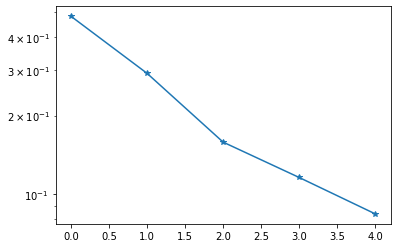

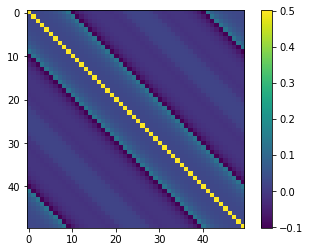

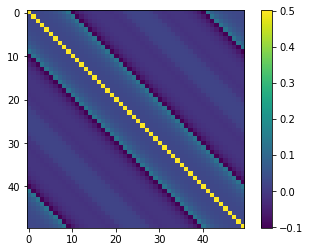

In [36]:
# "Naive" direct self-consistent iteration
rho = init_rho.copy()
norm_diff = []
mu_list = []
trace_list = []
for i in range(300):
    func_args['mu'] = cp.get_mu(rho, H, ovlp)
    mu_list.append(func_args['mu'])
    
    trace_list.append(rho.trace())
    rho_next = gcp.steady_linear_single_step(rho, **func_args)
    norm_diff.append(linalg.norm(rho_next - rho))
    rho = rho_next
    if norm_diff[-1] < 1e-10:
        break

        
rho = init_rho.copy()
norm_diff = []
mu_list = []
trace_list = []
for i in range(5):
    mu_list.append(func_args['mu'])    
    trace_list.append(rho.trace())
    rho_next = gcp.steady_linear_single_step(rho, **func_args)
    norm_diff.append(linalg.norm(rho_next - rho))
    rho = rho_next
    if norm_diff[-1] < 1e-10:
        break
plt.figure(1)
plt.semilogy(norm_diff, '*-')

plt.figure(2)
plt.imshow(rho.real)
plt.colorbar()

print(linalg.norm(exact_2 - rho))

for i in range(10):
    rho_sq = rho @ rho
    rho_cu = rho @ rho_sq
    rho = 3*rho_sq - 2*rho_cu
 
plt.figure(3)
plt.imshow(rho.real)
plt.colorbar()

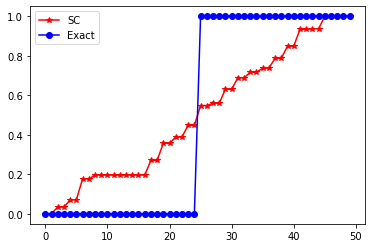

In [37]:
eigsh = linalg.eigvalsh(rho)
exact_eigs = linalg.eigvalsh(exact_2)
plt.plot(eigsh, 'r-*', label="SC")
plt.plot(exact_eigs, 'b-o', label="Exact")
plt.legend(numpoints=1)

In [11]:
mu_list

[(0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.4127268134710518+0j),
 (0.41272681

In [12]:
trace_list

[(24.999121209138025+0j),
 (25.703826141055014+0j),
 (26.204102305398187+0j),
 (26.302216107953107+0j),
 (26.252822190551168+0j),
 (26.173698158404136+0j),
 (26.084228697483198+0j),
 (25.99008105527141+0j),
 (25.894593527712892+0j),
 (25.800555832287273+0j),
 (25.709886340581562+0j),
 (25.623704468787565+0j),
 (25.542506376313362+0j),
 (25.466372103636004+0j),
 (25.395137677175022+0j),
 (25.328518021593837+0j),
 (25.266185346697156+0j),
 (25.20781432753304+0j),
 (25.153105015729352+0j),
 (25.10179196255972+0j),
 (25.05364542335495+0j),
 (25.008468431175245+0j),
 (24.966092055353386+0j),
 (24.92637018753919+0j),
 (24.8891745826443+0j),
 (24.854390506380746+0j),
 (24.821913119513216+0j),
 (24.79164460401943+0j),
 (24.763491970810744+0j),
 (24.73736545884772+0j),
 (24.713177426569345+0j),
 (24.690841639337584+0j),
 (24.670272865433795+0j),
 (24.65138670461704+0j),
 (24.634099585358722+0j),
 (24.618328878474447+0j),
 (24.603993085398496+0j),
 (24.591012068538763+0j),
 (24.579307298958607+0

0.0


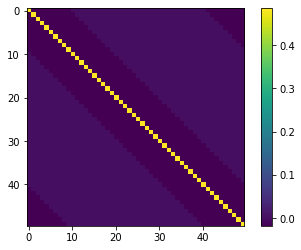

In [13]:
rho_i = init_rho.copy()
herm_check = []
trace_check = []
trace_check.append(rho_i.trace())
dbeta = 0.003
iden = np.identity(rho_i.shape[0])
inv_ovlp = ovlp.copy()
B = inv_ovlp @ H
B += B.conj().T
B/= 2
print(linalg.norm(B - B.conj().T))
for i in range(1000):
    A = inv_ovlp @ rho_i
    A += A.conj().T
    A /= 2
    
    K = -dbeta/2 * (iden - A) @ (B - mu*iden)
    Kdag = -dbeta/2 * (B - mu*iden) @ (iden - A)
    
    rho_next = (iden + Kdag) @ rho_i @ (iden + K)
    herm_check.append(linalg.norm(rho_next - rho_next.conj().T))
    trace_check.append(rho_next.trace())
    rho_i = rho_next.copy()
    
plt.imshow(rho_i.real)
plt.colorbar()

In [14]:
trace_check[1:10]

[(24.998242597663157+0j),
 (24.99736398818748+0j),
 (24.996485381491503+0j),
 (24.99560677835575+0j),
 (24.99472817956072+0j),
 (24.993849585886903+0j),
 (24.99297099811477+0j),
 (24.99209241702477+0j),
 (24.991213843397354+0j)]

In [15]:
print(linalg.norm(exact3 - rho_i))
print(linalg.norm(exact3 - dmm_gcp_rho))

3.279581021628478
7.328688042543661e-06


Text(0.5, 1.0, 'Norm Diff of Steady State')

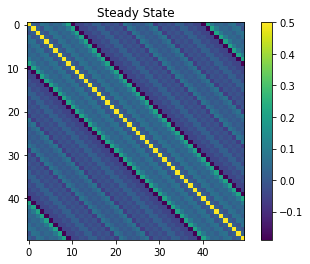

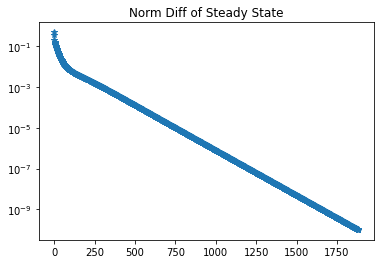

In [16]:
# Steady state
rho_i = init_rho.copy()
herm_check = []
trace_check = []
trace_check.append(rho_i.trace())
dbeta = 0.003
iden = np.identity(rho_i.shape[0])
inv_ovlp = ovlp.copy()
B = inv_ovlp @ H
Bdag = H @ inv_ovlp

norm_diff = []
for i in range(100000):
    A = inv_ovlp @ rho_i
    Adag = rho_i @ inv_ovlp
    rho_next = (iden + Bdag) @ rho_i @ (iden + B) - Bdag @ rho_i @ B
    rho_next += Bdag @ Adag @ rho_i @ A @ B - (iden + Bdag @ Adag) @ rho_i @ (iden + A @ B)
    rho_next += 2 * mu * (rho_i @ A)
    rho_next /= (2*mu)
    
    norm_diff.append(linalg.norm(rho_next - rho_i))
    if norm_diff[-1] < 1e-10:
        break
    
    rho_i = rho_next.copy()

plt.figure(1)
plt.imshow(rho_i.real)
plt.title("Steady State")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, '*-')
plt.title("Norm Diff of Steady State")

7.071067809077983
7.071065681655171
9.800258796091295e-09
8.999003860249697e-15


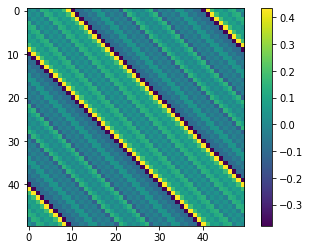

In [17]:
print(linalg.norm(rho_i - exact_2))
print(linalg.norm(rho_i - exact3))
plt.imshow(rho_i.real - exact_2.real)
plt.colorbar()
print(np.linalg.norm(rho_i @ rho_i - rho_i))
print(np.linalg.norm(exact_2 @ exact_2 - exact_2))

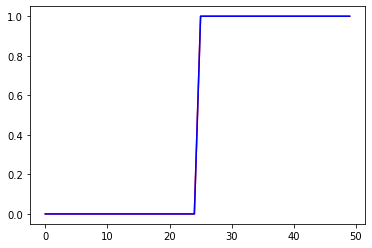

In [18]:
plt.plot(linalg.eigvalsh(rho_i), 'r-')
plt.plot(linalg.eigvalsh(exact_2), 'b-')

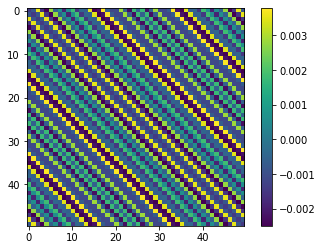

In [19]:
plt.imshow(rho.real - rho_i.real)
plt.colorbar()